In [39]:
import numpy as np
import numba
from numba.types import *
from numba import prange
import matplotlib.pyplot as plt
from numpy.linalg import eig, multi_dot, inv
from numpy import sin
from numpy import pi
from scipy.optimize import curve_fit
from scipy.linalg import schur
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size']=20
from scipy.linalg import expm
from numpy.linalg import matrix_power
from scipy.stats import linregress
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import eval_genlaguerre, gamma, hyp1f1
from math import acos, factorial

In [40]:
S=50
dim=int(2*S+1)
τ=1
i=complex(0, 1)
basis = np.identity(dim)
#N_av=100

In [41]:
#Definition of the ladder operators
@numba.jit(numba.types.Tuple((float64, float64[:]))(float64[:], float64), nopython=True, fastmath=True, parallel=False)
def S_p(ket, S):
    site= np.argmax(ket)
    m=site-S
    ket_out=np.zeros(dim)
    if site== 2*S:
        coef=0
        return (coef, ket_out)
    else:
        coef=np.sqrt(S*(S+1)-m*(m+1))
        ket_out[site+1]= 1
        return (coef, ket_out)
@numba.jit(numba.types.Tuple((float64, float64[:]))(float64[:], float64), nopython=True, fastmath=True, parallel=False)
def S_m(ket, S):
    site= np.argmax(ket)
    m=site-S
    ket_out=np.zeros(dim)
    if site== 0:
        coef=0
        return (coef, ket_out)
    else:
        coef= np.sqrt(S*(S+1)-m*(m-1))
        ket_out[site-1]= 1
        return (coef, ket_out)

In [42]:
@numba.jit(float64(float64[:], float64[:]), nopython=True, fastmath=True, parallel=False)
def braket(bra, ket):
    if np.all(bra== ket):
        return 1
    else:
        return 0

In [43]:
@numba.jit(float64[:,:](float64[:, :], float64), nopython=True, fastmath=True, parallel=False)
def Compute_Sx(basis, S):
    dim=int(2*S+1)
    Sx=np.zeros((dim, dim))
    for j in range(dim):
        for k in range(dim):
            ket=basis[j, :]
            bra=basis[k, :]
            coef_p, S_p_ket=S_p(ket, S)
            coef_m, S_m_ket=S_m(ket, S)
            result_p=braket(bra, S_p_ket)
            result_m=braket(bra, S_m_ket)
            Sx[j, k]=(coef_p*result_p+ coef_m*result_m)/2
    return Sx

@numba.jit(complex128[:,:](float64[:, :], float64), nopython=True, fastmath=True, parallel=False)
def Compute_Sy(basis, S):
    dim=int(2*S+1)
    Sy=np.zeros((dim, dim), dtype=complex128)
    i=complex(0,1)
    for j in range(dim):
        for k in range(dim):
            ket=basis[j, :]
            bra=basis[k, :]
            coef_p, S_p_ket=S_p(ket, S)
            coef_m, S_m_ket=S_m(ket, S)
            result_p=braket(bra, S_p_ket)
            result_m=braket(bra, S_m_ket)
            Sy[j, k]=-i*(coef_p*result_p- coef_m*result_m)/2
    return Sy

@numba.jit(float64[:,:](float64), nopython=True, fastmath=True, parallel=False)
def Compute_Sz(S):
    dim=int(2*S+1)
    Sz=np.zeros((dim, dim))
    for j in range(dim):
        m=j-S
        Sz[dim-1-j, dim-1-j]=m
    return Sz
def BrodyDist(s, br):
    b=(gamma((br+ 2)/(br + 1)))**(br + 1)
    return (br + 1)*b*s**br*np.exp(-b*s**(br+1))
def unfoldSpectrum(E, order, n_bins, N):
    Emax=np.max(E)
    Emin=np.min(E)
    rhoE, bins=np.histogram(E, bins=np.linspace(Emin, Emax, n_bins+1), density='True')
    bins=bins[:-1]
    N_E=np.zeros(n_bins)
    dummyE=0
    dE=(bins[1]-bins[0])
    for k in range(n_bins):
        dummyE+=rhoE[k]*dE
        N_E[k]=dummyE
    fit=np.polyfit(bins, N_E, order)
    polyn=np.poly1d(fit)
    unf_E=N*polyn(E)
    rhoE_unf, bins=np.histogram(unf_E, bins=np.linspace(np.min(unf_E), np.max(unf_E), n_bins+1), density='True')
    stdrho=np.std(rhoE_unf)
    #plt.bar(bins[:-1], rhoE_unf, width=(bins[1]-bins[0]))
    #plt.hlines(1/N+2*stdrho, 0, N)
    #plt.hlines(1/N-2*stdrho, 0, N)
    #plt.show()
    ndiscard=np.sum(rhoE_unf>1/N+2*stdrho) # # bins with ρ(E)>1/N+2σ. # bins to discard
    #print(ndiscard)
    unf_E=unf_E[unf_E>bins[ndiscard]]
    unf_E=unf_E[unf_E<bins[-1-ndiscard]]
    return unf_E
#@numba.njit()
def compute_eps(U):
    eval_U=np.linalg.eigvals(U)
    logeval=np.log(eval_U)/i
    aux=np.real(logeval)
    idx=np.argsort(aux)
    E=aux[idx] #from -π to +π
    #unf_E=unfoldSpectrum(E, order_polyn, n_bins, dim)
    #s_list=np.diff(unf_E)
    return E
    #return unf_E

In [44]:
def Z(σ, E):
    return np.sum(np.exp(σ*E))
def g(σ, E):
    nE=len(E)
    deltaE=np.zeros((nE, nE))
    for l in range(nE):
        for j in range(nE):
            deltaE[j,l]=E[j]-E[l]
    return np.sum(np.exp(σ*deltaE))

In [45]:
Sx=np.zeros((dim, dim))
Sy=np.zeros((dim, dim), dtype=complex)
Sx=Compute_Sx(basis, S)
Sy=Compute_Sy(basis, S) #I've checked that for S=1/2, 1, 3/2 the results are the expected ones
Sz=Compute_Sz(S)

In [71]:
order_polyn=10
n_bins=70
#Parameters of generalized QKT
pz=1
kz=10
py=1
ky=0
px=0
kx=0

t_arr=np.arange(0, 1000, 1)
n_p_t=len(t_arr)
nt2=50*n_p_t
t_arr2=np.linspace(-2, np.log10(t_arr[-1]), nt2)
t_arr2=10**t_arr2
β=1
#Not averaging 
"""Nav=1
U=expm(-i*kz*Sz@Sz/dim - i*pz*Sz)@expm(-i*ky*Sy@Sy/dim - i*py*Sy)@expm(-i*kx*Sx@Sx/dim - i*px*Sx)
pseudoE=compute_eps(U)"""
#Averaging part
dk=0.1*kz
Nav=50
k_av=kz+dk*(np.random.rand(Nav)-0.5)
pseudoE=np.zeros((dim, Nav))
for j in range(Nav):
    U=expm(-i*k_av[j]*Sz@Sz/dim - i*pz*Sz)@expm(-i*ky*Sy@Sy/dim - i*py*Sy)@expm(-i*kx*Sx@Sx/dim - i*px*Sx)
    pseudoE[:,j]=compute_eps(U)

In [72]:
#not averaging
"""SFF=np.zeros(n_p_t)
SFF2=np.zeros(nt2)
for j in range(n_p_t):
    SFF[j]=(np.abs(Z(β/2+2*i*t_arr[j], pseudoE)))**2
for j in range(nt2):
    SFF2[j]=(np.abs(Z(β/2+2*i*t_arr2[j], pseudoE)))**2"""
#averaging
SFF=np.zeros((n_p_t, Nav))
SFF2=np.zeros((nt2, Nav))
#pseudoE=pseudoE.flatten()
for l in range(Nav):
    for j in range(n_p_t):
        SFF[j, l]=(np.abs(Z(β+i*t_arr[j], pseudoE[:,l])))**2
    for j in range(nt2):
        SFF2[j, l]=(np.abs(Z(β+i*t_arr2[j], pseudoE[:,l])))**2

In [73]:
SFF_=np.average(SFF, axis=1)
SFF2_=np.average(SFF2, axis=1)
sigma2=np.std(SFF2, axis=1)
sigma=np.std(SFF, axis=1)

In [74]:
#Compute the averaged (analytically continued) Partition Function for the GUE.
def avZGUE(sigma, dim):
    return np.exp(sigma**2/4)*eval_genlaguerre(dim-1, 1, -sigma**2/2)
    #return np.exp(sigma**2/4)*GenLag(dim-1, 1, -sigma**2/2)
#Compute the connected part of the SFF averaged for the GUE
def gcGUE(sigma0, dim):
    gc=0
    for n in range(dim):
        for m in range(dim):
            cmn=factorial(np.min([n,m]))/factorial(np.max([n, m]))
            dnm=np.abs(n-m)
            minnm=np.min([n,m])
            poly=eval_genlaguerre(minnm, dnm, -sigma0**2/2)
            gc+=cmn*(np.conjugate(sigma0)*sigma0/2)**dnm*np.conjugate(poly)*poly
    return -np.exp((sigma0**2+(np.conjugate(sigma0))**2)/4)*gc
#COmpute the total SFF averaged over the GUE
def avgGUE(beta, t, dim):
    term1=avZGUE(2*beta, dim)
    term2=avZGUE(beta+i*t, dim)
    #term2=(np.abs(term2))**2
    term2=np.conjugate(term2)*term2
    term3=gcGUE(beta+i*t, dim)
    return term1+term2+term3
#g_analytic=avgGUE(β, t_arr2, dim)

In [75]:
def expF(t, a, b):
    return a*np.exp(-b*t)
def LogMean(x, y):
    return np.exp((np.log(x)+np.log(y))/2)
def linFit(x, res):
    return res.slope*x+res.intercept
def evenlySpacedFPoints(Fmax, Fmin, npoints):
    arrexp=np.linspace(0, np.log10(Fmax/Fmin), npoints)
    arr=Fmin*10**arrexp
    return arr
def fit_eta(coef_range, n_fits, fhat, t_arr):
    #First we will find the first dip (need not be the deepest one) and take only those values
    #Gives the relative minima of fhat
    #arr_minima=np.r_[True, fhat[1:] < fhat[:-1]] & np.r_[fhat[:-1] < fhat[1:], True]
    #arr_minima=np.abs(np.gradient(fhat))<1e-12
    #t_dip=np.min(t_arr[arr_minima]) #we take the smallest of those relative minima
    #dt=t_arr[1]-t_arr[0]
    
    #fhat_aux=np.append(fhat, fhat[-1])
    t_dip=t_arr[np.where(np.diff(np.sign(np.gradient(fhat))) > 0)[0][0]+2]
    fhat_aux=fhat[t_arr<t_dip] #Take only the values of fhat before the dip
    t_arr_aux=t_arr[t_arr<t_dip]
    pInflect=np.argmin(np.diff(fhat_aux)) #gives the inflection point of fhat
    FInflect=fhat[pInflect]
    pInflectlog=np.argmin(np.diff(np.log(fhat_aux))) #gives the inflection point of log(fhat)
    FInflectLog=fhat[pInflectlog]
    #We will fit the Lyapunov in n_regions_fitted points between the FInflectLog and FInflect
    centerFitArr=evenlySpacedFPoints(FInflect, FInflectLog, n_fits)
    auxlambda=[]
    auxerr=[]
    auxn=[]
    #For every fitted point we compute the variance of the fit to a linear f(t)=a t + b (after 
    #taking the log) and the variance of the fit to a quadratic function h(t)=a' t^2 + b. 
    #We take the value of the Lyapunov (linear fit) if Var_linear<Var_quadratic or if
    #Var_linear<cutoffVar.
    cutoffVar=1e-4
    for j in range(len(centerFitArr)):
        minF_fit=centerFitArr[j]-coef_range*(centerFitArr[j]-fhat_aux[-1])
        maxF_fit=centerFitArr[j]+coef_range*(centerFitArr[j]-fhat_aux[-1])
        F_fit=fhat_aux[fhat_aux>minF_fit]
        t_fit=t_arr_aux[fhat_aux>minF_fit]
        t_fit=t_fit[F_fit<maxF_fit]
        F_fit=F_fit[F_fit<maxF_fit]
        logF=-np.log(F_fit)
        res=linregress(t_fit, logF)
        res2=linregress(t_fit**2, logF)
        Var=np.sum((linFit(t_fit, res)-logF)**2)
        Var2=np.sum((linFit(t_fit**2, res2)-logF)**2)
        if Var<Var2 or Var<cutoffVar:
            auxlambda.append(res.slope)
            auxerr.append(res.stderr)
            auxn.append(res.intercept)
    lyap=np.average(auxlambda)
    linearcoef=np.average(auxn)
    auxerr=np.asarray(auxerr)
    std_lyap=np.sqrt((np.std(auxlambda))**2+np.sum(auxerr**2))
    return lyap, std_lyap, linearcoef, np.min(auxlambda), np.max(auxlambda)

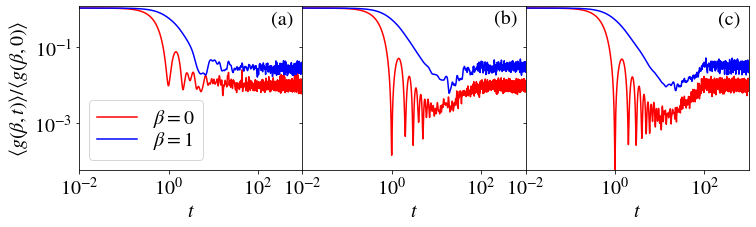

In [101]:

fig, (ax1, ax2, ax3)= plt.subplots(1, 3, sharey=True, figsize=[12, 3])
ax1.plot(t_arr2, auxbeta0Poi, color='red', label=r"$\beta = 0$")
ax1.plot(t_arr2, auxbeta1Poi, color='blue', label=r"$\beta = 1$")
ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.plot(t_arr2, auxbeta0GOE, color='red', label=r"$\beta = 0$")
ax2.plot(t_arr2, auxbeta1GOE, color='blue', label=r"$\beta = 1$")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax3.plot(t_arr2, auxbeta0GUE, color='red', label=r"$\beta = 0$")
ax3.plot(t_arr2, auxbeta1GUE, color='blue', label=r"$\beta = 1$")
ax3.set_yscale('log')
ax3.set_xscale('log')
plt.subplots_adjust(wspace=0)
ax1.set_ylabel(r"$\langle g(\beta, t) \rangle/\langle g(\beta, 0) \rangle$")
ax1.set_xlabel("$t$")
ax2.set_xlabel("$t$")
ax3.set_xlabel("$t$")
ax1.set_ylim(np.min(auxbeta0GUE), 1.1)
ax1.set_xlim(t_arr2[0], t_arr2[-1])
ax2.set_xlim(t_arr2[0], t_arr2[-1])
ax3.set_xlim(t_arr2[0], t_arr2[-1])
ax1.text(200, 0.4, "(a)")
ax2.text(200, 0.4, "(b)")
ax3.text(200, 0.4, "(c)")
ax1.legend(labelspacing=0)
#plt.plot(t_arr2, g_analytic/g_analytic[0], color='blue')
#plt.errorbar(t_arr, SFF_, yerr=sigma, ls='None')
#plt.scatter(t_arr, SFF_/SFF_[0], color='black', label=r"$t \in \mathbb{N}$")
#plt.hlines(1, t_arr2[0], t_arr2[-1], color='grey')
"""plt.yscale('log')
plt.xlim(t_arr2[0], t_arr[-1])
plt.ylim(1e-5, 1)
#plt.ylim(0.1, 1000)
plt.xscale('log')
plt.xlabel("$t$")
plt.ylabel(r"$\langle g(\beta, t) \rangle/\langle g(\beta, 0) \rangle$")
plt.legend()"""
plt.show()

In [78]:
#Accumulate the data to make the whole 3 plots

#auxbeta0GUE=SFF2_/SFF2_[0]
#auxbeta1GUE=SFF2_/SFF2_[0]
#auxbeta1Poi=SFF2_/SFF2_[0]
#auxbeta0Poi=SFF2_/SFF2_[0]
#auxbeta0GOE=SFF2_/SFF2_[0]
#auxbeta1GOE=SFF2_/SFF2_[0]

In [ ]:
"""plt.figure()
plt.plot(t_arr2, SFF2/SFF2[0], color='red', alpha=0.7)
#plt.plot(t_arr2, g_analytic/g_analytic[0], color='blue')
#plt.errorbar(t_arr, SFF_, yerr=sigma, ls='None')
plt.scatter(t_arr, SFF/SFF[0], color='black')
plt.plot(t_arr2, np.exp(-(eta*t_arr2+lin)))
plt.plot(t_arr2, np.exp(-(max_eta*t_arr2+2*lin)))
plt.plot(t_arr2, np.exp(-(min_eta*t_arr2+0.1*lin)))
#plt.plot(t_arr2, np.exp(-(eta_analyt*t_arr2+lin_analyt)))
plt.hlines(1, t_arr2[0], t_arr2[-1], color='grey')
plt.yscale('log')
plt.xlim(0, 2)
plt.ylim(1e-4, 1)
#plt.ylim(0.1, 1000)
#plt.xscale('log')
plt.show()"""